In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3

In [2]:
import os
import cv2
import numpy as np
import shutil
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import os

def convert_polygons_to_yolo_bbox_safe(label_dir, new_label_dir):
    os.makedirs(new_label_dir, exist_ok=True)
    
    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):
            filepath = os.path.join(label_dir, filename)
            new_filepath = os.path.join(new_label_dir, filename)
            
            new_lines = []
            with open(filepath, "r") as f:
                lines = f.read().strip().split("\n")
                
            for line in lines:
                parts = line.strip().split()
                if len(parts) > 1:
                    class_id = parts[0]
                    coords = list(map(float, parts[1:]))
                    if len(coords) % 2 == 0:
                        xs = coords[::2]
                        ys = coords[1::2]
                        min_x, max_x = min(xs), max(xs)
                        min_y, max_y = min(ys), max(ys)
                        x_center = (min_x + max_x) / 2
                        y_center = (min_y + max_y) / 2
                        width = max_x - min_x
                        height = max_y - min_y
                        new_line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
                        new_lines.append(new_line)
            
            # Write new file
            with open(new_filepath, "w") as f:
                f.write("\n".join(new_lines))

# Example:
convert_polygons_to_yolo_bbox_safe(
    '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/labels',
    '/kaggle/working/train/labels')
convert_polygons_to_yolo_bbox_safe(
    '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/labels',
    '/kaggle/working/valid/labels')
convert_polygons_to_yolo_bbox_safe(
    '/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/labels',
    '/kaggle/working/test/labels')

In [4]:
label_map = {'0':'0', '1':'1', '2':'2', '4':'3', '5':'4', '6':'5'}

folders = [
    '/kaggle/working/train/labels',
    '/kaggle/working/valid/labels',
    '/kaggle/working/test/labels'
]

for folder in folders:
    for file in os.listdir(folder):
        if file.endswith('.txt'):
            path = os.path.join(folder, file)
            with open(path, 'r') as f:
                lines = f.readlines()
            new_lines = []
            for line in lines:
                parts = line.strip().split()
                old_label = parts[0]
                if old_label in label_map:
                    parts[0] = label_map[old_label]
                    new_lines.append(' '.join(parts))
                else:
                    print(f"Warning: unknown label {old_label} in {file}")
            with open(path, 'w') as f:
                f.write('\n'.join(new_lines))

In [5]:
def copy_images(src_image_dir, dst_image_dir):
    os.makedirs(dst_image_dir, exist_ok=True)
    for filename in os.listdir(src_image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            shutil.copy2(os.path.join(src_image_dir, filename),
                         os.path.join(dst_image_dir, filename))

copy_images('/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/train/images',
            '/kaggle/working/train/images')

copy_images('/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/valid/images',
            '/kaggle/working/valid/images')

copy_images('/kaggle/input/bone-fracture-detection-computer-vision-project/BoneFractureYolo8/test/images',
            '/kaggle/working/test/images')

In [6]:
yaml_content = """
train: /kaggle/working/train/images
val: /kaggle/working/valid/images
test: /kaggle/working/test/images

nc: 6
names: ['elbow positive', 'fingers positive', 'forearm fracture',
        'humerus fracture', 'shoulder fracture', 'wrist positive']
"""

with open('/kaggle/working/bonefracture.yaml', 'w') as f:
    f.write(yaml_content.strip())

In [7]:
from ultralytics import YOLO
model = YOLO('yolo11n.pt')
# freeze backbone
for name, param in model.model.named_parameters():
    if 'backbone' in name:     # or use layer names
        param.requires_grad = False
model.train(data='/kaggle/working/bonefracture.yaml', epochs=50, imgsz=640, batch=16, name="first_train")

100%|██████████| 5.35M/5.35M [00:00<00:00, 77.2MB/s]


Ultralytics 8.3.163 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/bonefracture.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=first_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

100%|██████████| 755k/755k [00:00<00:00, 18.8MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/train/labels... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:02<00:00, 1627.52it/s]


train: New cache created: /kaggle/working/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 307.0±110.9 MB/s, size: 9.2 KB)


val: Scanning /kaggle/working/valid/labels... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<00:00, 1587.02it/s]

val: New cache created: /kaggle/working/valid/labels.cache


Plotting labels to runs/detect/first_train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/first_train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.21G      2.788      6.991      2.302         22        640: 100%|██████████| 227/227 [00:40<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.18it/s]


                   all        348        204     0.0005      0.268    0.00154   0.000405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.64G      2.599      5.392      2.086         11        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]

                   all        348        204      0.718    0.00388     0.0137    0.00343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.65G      2.517      4.404      2.087         17        640: 100%|██████████| 227/227 [00:38<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.56it/s]

                   all        348        204      0.562     0.0579     0.0427     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.66G      2.489      4.009      2.082         18        640: 100%|██████████| 227/227 [00:38<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.11it/s]

                   all        348        204      0.641     0.0653     0.0628     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.68G      2.415      3.718      2.056         11        640: 100%|██████████| 227/227 [00:38<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.01it/s]


                   all        348        204      0.313      0.118     0.0844     0.0231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.69G       2.35      3.499      1.998         18        640: 100%|██████████| 227/227 [00:38<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.17it/s]

                   all        348        204      0.145      0.143     0.0971     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.71G      2.309      3.323      1.973         13        640: 100%|██████████| 227/227 [00:38<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.17it/s]

                   all        348        204      0.655     0.0946      0.104     0.0358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.72G      2.296      3.183      1.975         22        640: 100%|██████████| 227/227 [00:37<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.31it/s]

                   all        348        204      0.327      0.156      0.117     0.0421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.74G      2.224      3.089      1.956         21        640: 100%|██████████| 227/227 [00:38<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.99it/s]

                   all        348        204      0.477      0.131      0.123     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.75G        2.2      2.995      1.922         16        640: 100%|██████████| 227/227 [00:38<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.25it/s]

                   all        348        204      0.197      0.193      0.163     0.0614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.77G      2.202      2.985      1.919         10        640: 100%|██████████| 227/227 [00:38<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.20it/s]

                   all        348        204      0.239      0.211      0.157     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.79G      2.173      2.861      1.914         11        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.36it/s]

                   all        348        204      0.197      0.197      0.137     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       2.8G      2.101      2.746      1.867         13        640: 100%|██████████| 227/227 [00:38<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.50it/s]

                   all        348        204      0.207      0.222      0.162     0.0626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.81G      2.115      2.707      1.866         19        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.28it/s]

                   all        348        204      0.302      0.255      0.194       0.07



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.83G      2.081      2.661      1.847         14        640: 100%|██████████| 227/227 [00:38<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.33it/s]

                   all        348        204      0.169      0.265      0.134     0.0465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.84G      2.089      2.605      1.839         16        640: 100%|██████████| 227/227 [00:38<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]

                   all        348        204      0.227      0.228      0.194     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.86G      2.063      2.551      1.807         18        640: 100%|██████████| 227/227 [00:38<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  5.43it/s]

                   all        348        204      0.255      0.178      0.175     0.0616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.88G      2.021      2.534       1.79         13        640: 100%|██████████| 227/227 [00:38<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.28it/s]

                   all        348        204      0.245      0.263      0.196     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.88G      2.026      2.454      1.804         16        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.32it/s]

                   all        348        204      0.307      0.254      0.222      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.9G      1.989      2.376      1.773         14        640: 100%|██████████| 227/227 [00:38<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.37it/s]

                   all        348        204      0.285      0.219      0.193     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.91G      1.962      2.327      1.747         14        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.77it/s]


                   all        348        204      0.302      0.289       0.24       0.09

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.93G      1.911      2.217       1.71         18        640: 100%|██████████| 227/227 [00:37<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.11it/s]

                   all        348        204      0.301       0.26      0.239     0.0818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.95G      1.923      2.229      1.731         12        640: 100%|██████████| 227/227 [00:38<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.35it/s]

                   all        348        204      0.259      0.324      0.245     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.96G      1.911      2.153      1.741         19        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.34it/s]

                   all        348        204       0.26      0.352      0.253     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.97G      1.872      2.101      1.706         11        640: 100%|██████████| 227/227 [00:38<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.60it/s]

                   all        348        204      0.255      0.249      0.214      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.99G      1.839      2.063      1.671         14        640: 100%|██████████| 227/227 [00:38<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.35it/s]

                   all        348        204      0.337      0.287      0.258     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         3G      1.835      2.029      1.668         10        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.49it/s]

                   all        348        204      0.316      0.233      0.232     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.02G      1.814      1.975      1.667         21        640: 100%|██████████| 227/227 [00:38<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.25it/s]

                   all        348        204       0.43      0.278       0.26      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.04G      1.796      1.937      1.633         14        640: 100%|██████████| 227/227 [00:38<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.85it/s]

                   all        348        204       0.25      0.308      0.242     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.05G      1.772      1.903      1.629         13        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]

                   all        348        204      0.324      0.287      0.248     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.06G      1.736      1.845      1.613         21        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.28it/s]

                   all        348        204      0.282       0.25      0.227     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.08G       1.72      1.801      1.605         17        640: 100%|██████████| 227/227 [00:38<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.31it/s]

                   all        348        204       0.29      0.287      0.227     0.0883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.09G      1.709      1.763      1.595         14        640: 100%|██████████| 227/227 [00:38<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.00it/s]

                   all        348        204      0.289      0.243      0.212     0.0792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.11G      1.689      1.721      1.574         21        640: 100%|██████████| 227/227 [00:38<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.13it/s]

                   all        348        204      0.384      0.246      0.224     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.12G      1.665      1.673      1.552         17        640: 100%|██████████| 227/227 [00:38<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.23it/s]

                   all        348        204      0.317      0.299      0.257      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.14G      1.654      1.667      1.542         11        640: 100%|██████████| 227/227 [00:38<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.68it/s]

                   all        348        204      0.423      0.225      0.254     0.0928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.15G      1.638      1.639      1.531         13        640: 100%|██████████| 227/227 [00:38<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.58it/s]

                   all        348        204       0.34      0.281      0.245     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.17G      1.631      1.607      1.524         12        640: 100%|██████████| 227/227 [00:39<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]

                   all        348        204       0.28      0.257      0.227     0.0853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.18G      1.581      1.529      1.489         22        640: 100%|██████████| 227/227 [00:38<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.52it/s]

                   all        348        204      0.278       0.26      0.246     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.2G      1.571      1.515      1.484         20        640: 100%|██████████| 227/227 [00:38<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.64it/s]

                   all        348        204      0.292      0.246      0.222     0.0916


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.21G      1.546      1.381      1.559          9        640: 100%|██████████| 227/227 [00:38<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.23it/s]

                   all        348        204      0.285      0.275      0.222     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.23G      1.477      1.326       1.52          9        640: 100%|██████████| 227/227 [00:37<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]

                   all        348        204      0.346      0.241      0.217     0.0851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.24G      1.463      1.272      1.508          8        640: 100%|██████████| 227/227 [00:37<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.25it/s]

                   all        348        204      0.308      0.288      0.239     0.0917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.26G      1.423      1.238       1.47          6        640: 100%|██████████| 227/227 [00:37<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]

                   all        348        204      0.291      0.283      0.234     0.0867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.27G      1.397      1.192      1.449          8        640: 100%|██████████| 227/227 [00:37<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  5.70it/s]

                   all        348        204      0.393       0.25      0.252     0.0933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.29G      1.351      1.172      1.429          7        640: 100%|██████████| 227/227 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.57it/s]

                   all        348        204      0.412      0.263       0.26     0.0984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       3.3G      1.331      1.109      1.404          8        640: 100%|██████████| 227/227 [00:38<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.03it/s]

                   all        348        204      0.419      0.231      0.263      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.32G      1.336      1.138        1.4         14        640: 100%|██████████| 227/227 [00:37<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.61it/s]

                   all        348        204      0.337      0.275      0.259      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.33G      1.317      1.099      1.399         11        640: 100%|██████████| 227/227 [00:37<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]

                   all        348        204      0.378      0.275      0.267      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.34G      1.279      1.087      1.371          7        640: 100%|██████████| 227/227 [00:37<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  6.58it/s]

                   all        348        204      0.437      0.254      0.265      0.106



50 epochs completed in 0.562 hours.
Optimizer stripped from runs/detect/first_train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/first_train/weights/best.pt, 5.4MB

Validating runs/detect/first_train/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.34it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        348        204      0.431      0.238      0.264      0.107
        elbow positive         28         29      0.202      0.172      0.116     0.0289
      fingers positive         41         48      0.405      0.146      0.174     0.0631
      forearm fracture         37         43      0.572      0.372      0.427      0.201
      humerus fracture         31         36      0.711      0.472       0.58      0.218
     shoulder fracture         19         20      0.435      0.194       0.23      0.115
        wrist positive         17         28       0.26     0.0714     0.0578     0.0177
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/first_train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c38a88b4190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

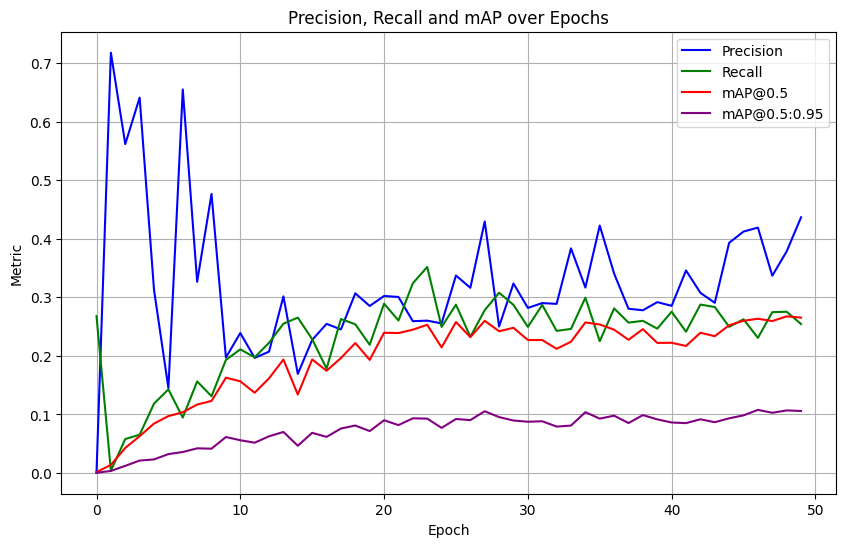

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('runs/detect/first_train/results.csv')

plt.figure(figsize=(10,6))

plt.plot(df.index, df['metrics/precision(B)'], label='Precision', color='blue')
plt.plot(df.index, df['metrics/recall(B)'], label='Recall', color='green')
plt.plot(df.index, df['metrics/mAP50(B)'], label='mAP@0.5', color='red')
plt.plot(df.index, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='purple')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Precision, Recall and mAP over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# # Load the best model you just trained
# model = YOLO('/kaggle/working/runs/detect/first_train5/weights/best.pt')

# # Continue training (fine-tuning)
# results = model.train(
#     data='/kaggle/working/bonefracture.yaml',
#     epochs=40,
#     lr0=1e-5,                # smaller learning rate
#     imgsz=640,
#     batch=32,
#     name="fine_tune"
# )

In [10]:
# results = model.train(
#     data='/kaggle/working/bonefracture.yaml',
#     epochs=50,
#     imgsz=640,
#     batch=16,
#     lr0=1e-4,
#     hsv_h=0.015,
#     hsv_s=0.7,
#     hsv_v=0.4,
#     fliplr=0.5,
#     mosaic=0.8,
#     translate=0.1,
#     scale=0.5,
#     shear=0.0,
#     project="fracture_yolo_project",
#     name="fine_tune_aug"
# )

In [11]:
# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')  # replace with your path

metrics = model.val(data='bonefracture.yaml', split='test', imgsz=225)

WARNING ⚠️ imgsz=[225] must be multiple of max stride 32, updating to [256]
Ultralytics 8.3.163 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 324.3±83.7 MB/s, size: 12.2 KB)


val: Scanning /kaggle/working/test/labels... 169 images, 86 backgrounds, 0 corrupt: 100%|██████████| 169/169 [00:00<00:00, 1606.66it/s]

val: New cache created: /kaggle/working/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01<00:00,  7.49it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        169         96      0.162      0.165     0.0829     0.0241
        elbow positive         13         17     0.0536     0.0588     0.0224    0.00512
      fingers positive         22         27      0.312      0.148      0.124      0.023
      forearm fracture         13         14      0.219      0.357      0.147     0.0449
      humerus fracture         14         15      0.233        0.2      0.153     0.0482
     shoulder fracture         15         17     0.0364     0.0588     0.0163     0.0054
        wrist positive          6          6      0.118      0.167     0.0341     0.0182
Speed: 0.6ms preprocess, 5.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/first_train2


In [12]:
print(metrics.box.map)       # mAP@0.5
print(metrics.box.map50)     # same as map
print(metrics.box.map75)     # mAP@0.75

0.02412471346983435
0.08289744325773121
0.011856451553156289


In [13]:
# Per-class AP values
per_class_ap = metrics.box.maps  # list of floats

for idx, ap in enumerate(per_class_ap):
    print(f"Class {idx}: AP={ap:.3f}")

Class 0: AP=0.005
Class 1: AP=0.023
Class 2: AP=0.045
Class 3: AP=0.048
Class 4: AP=0.005
Class 5: AP=0.018


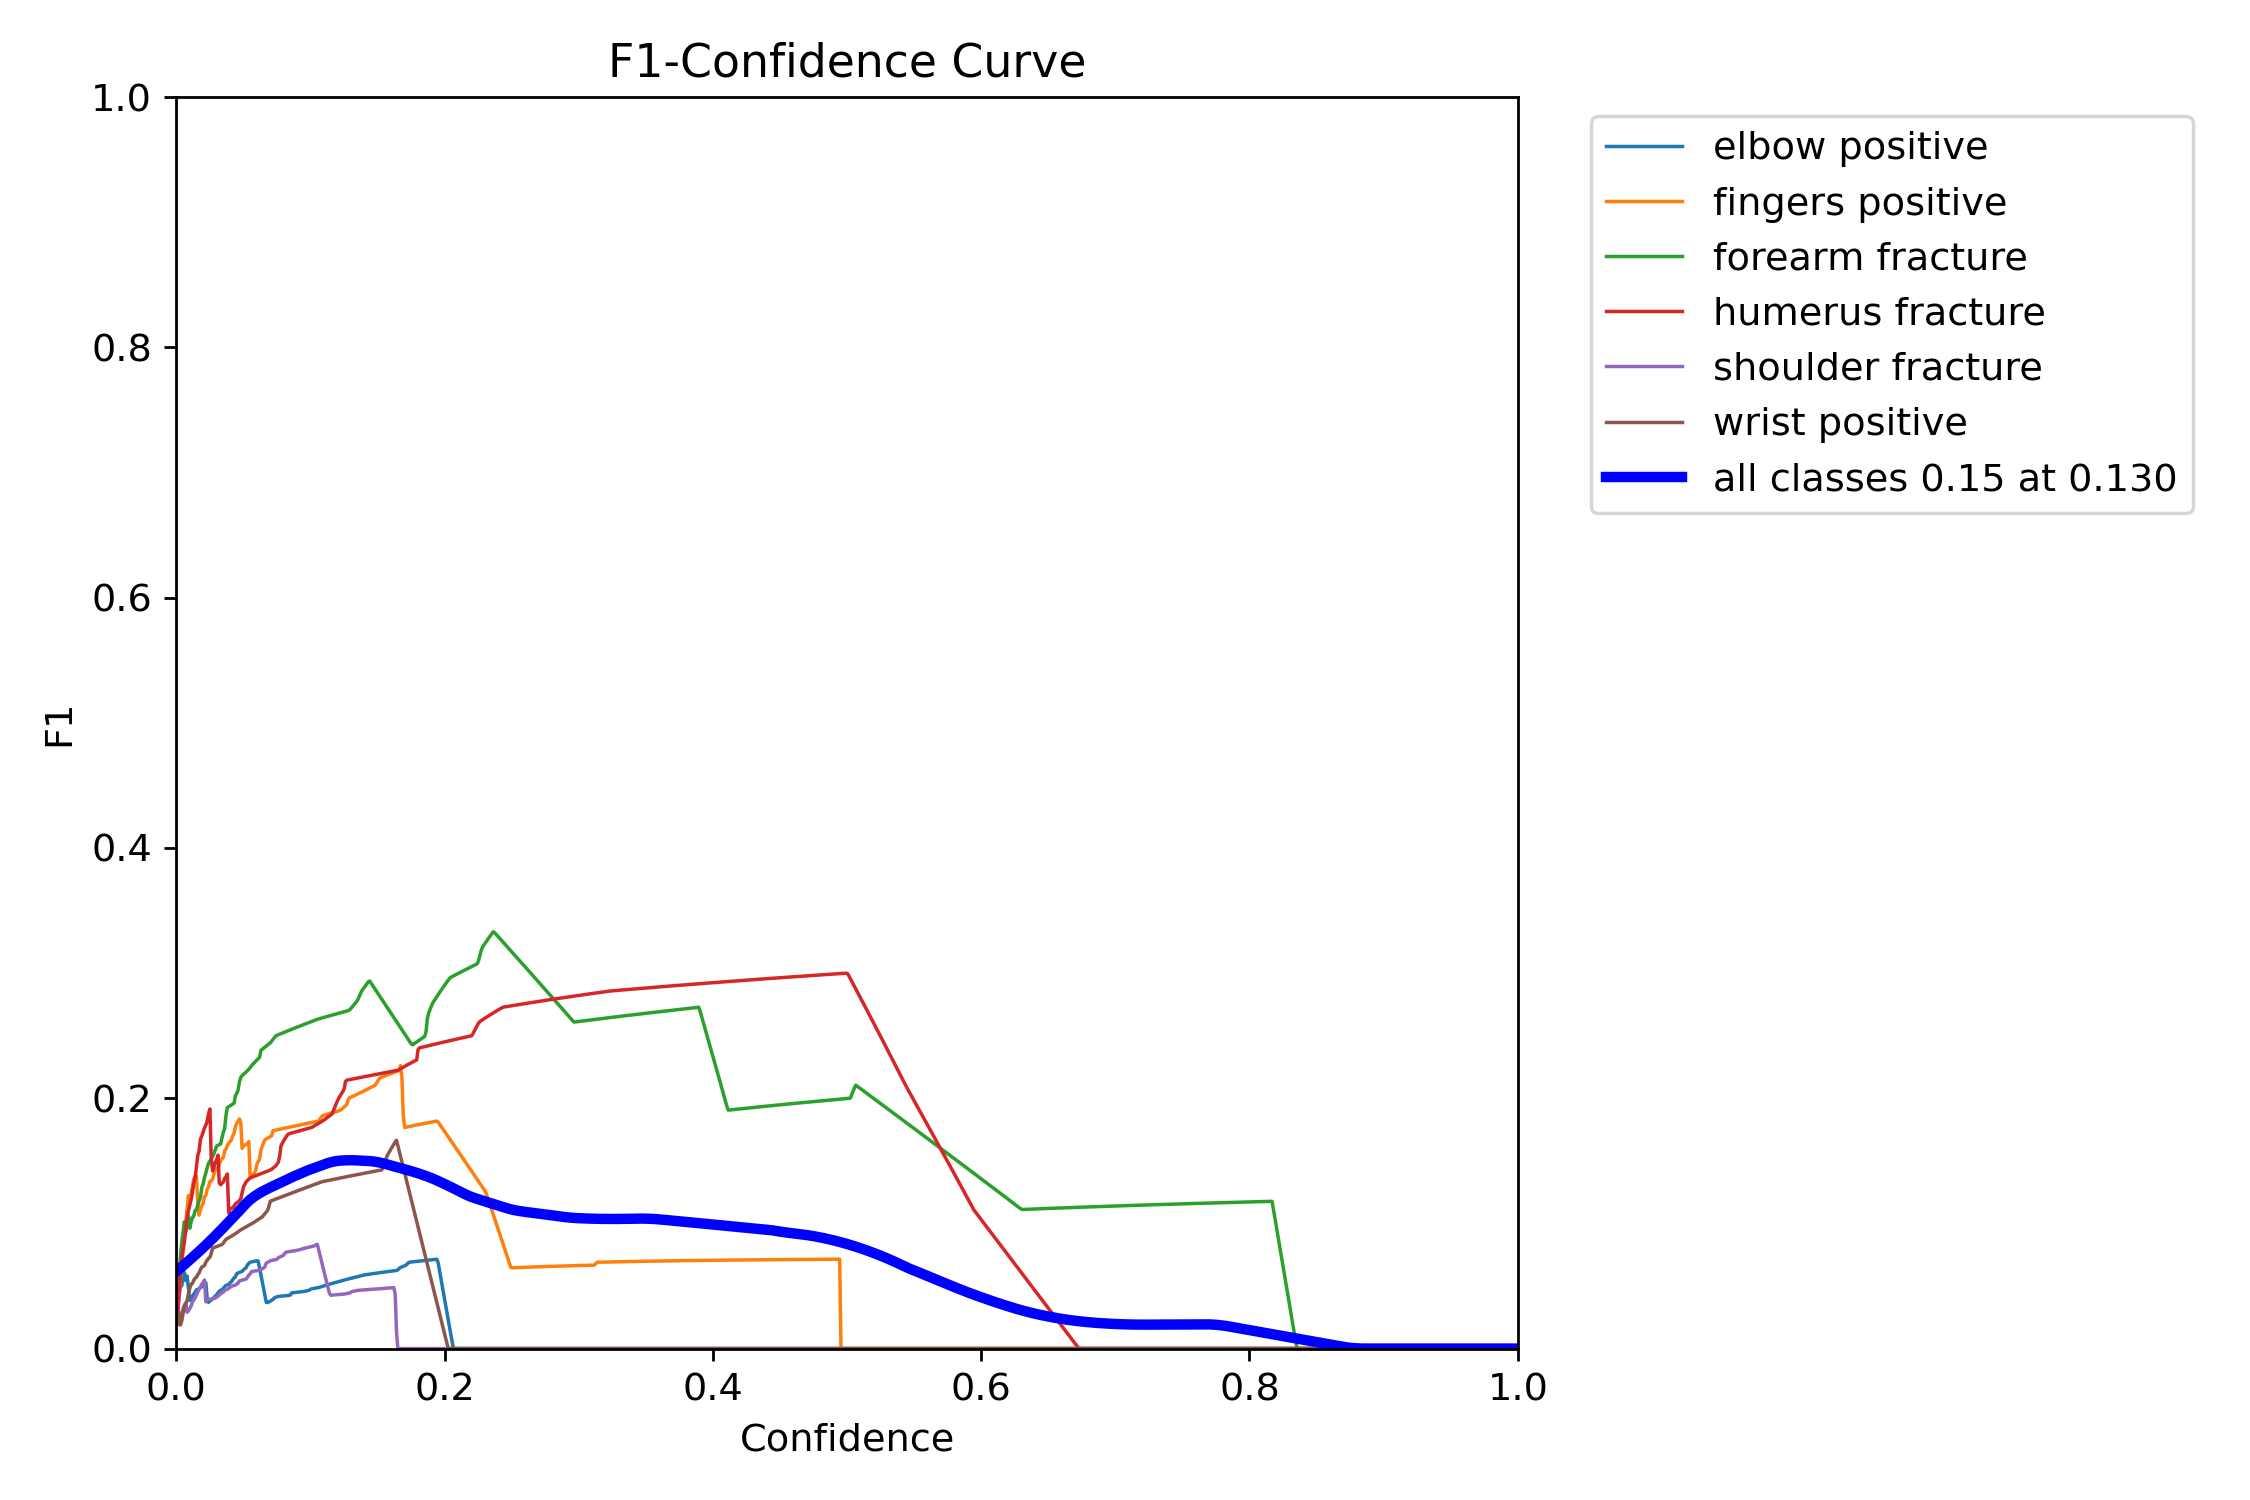

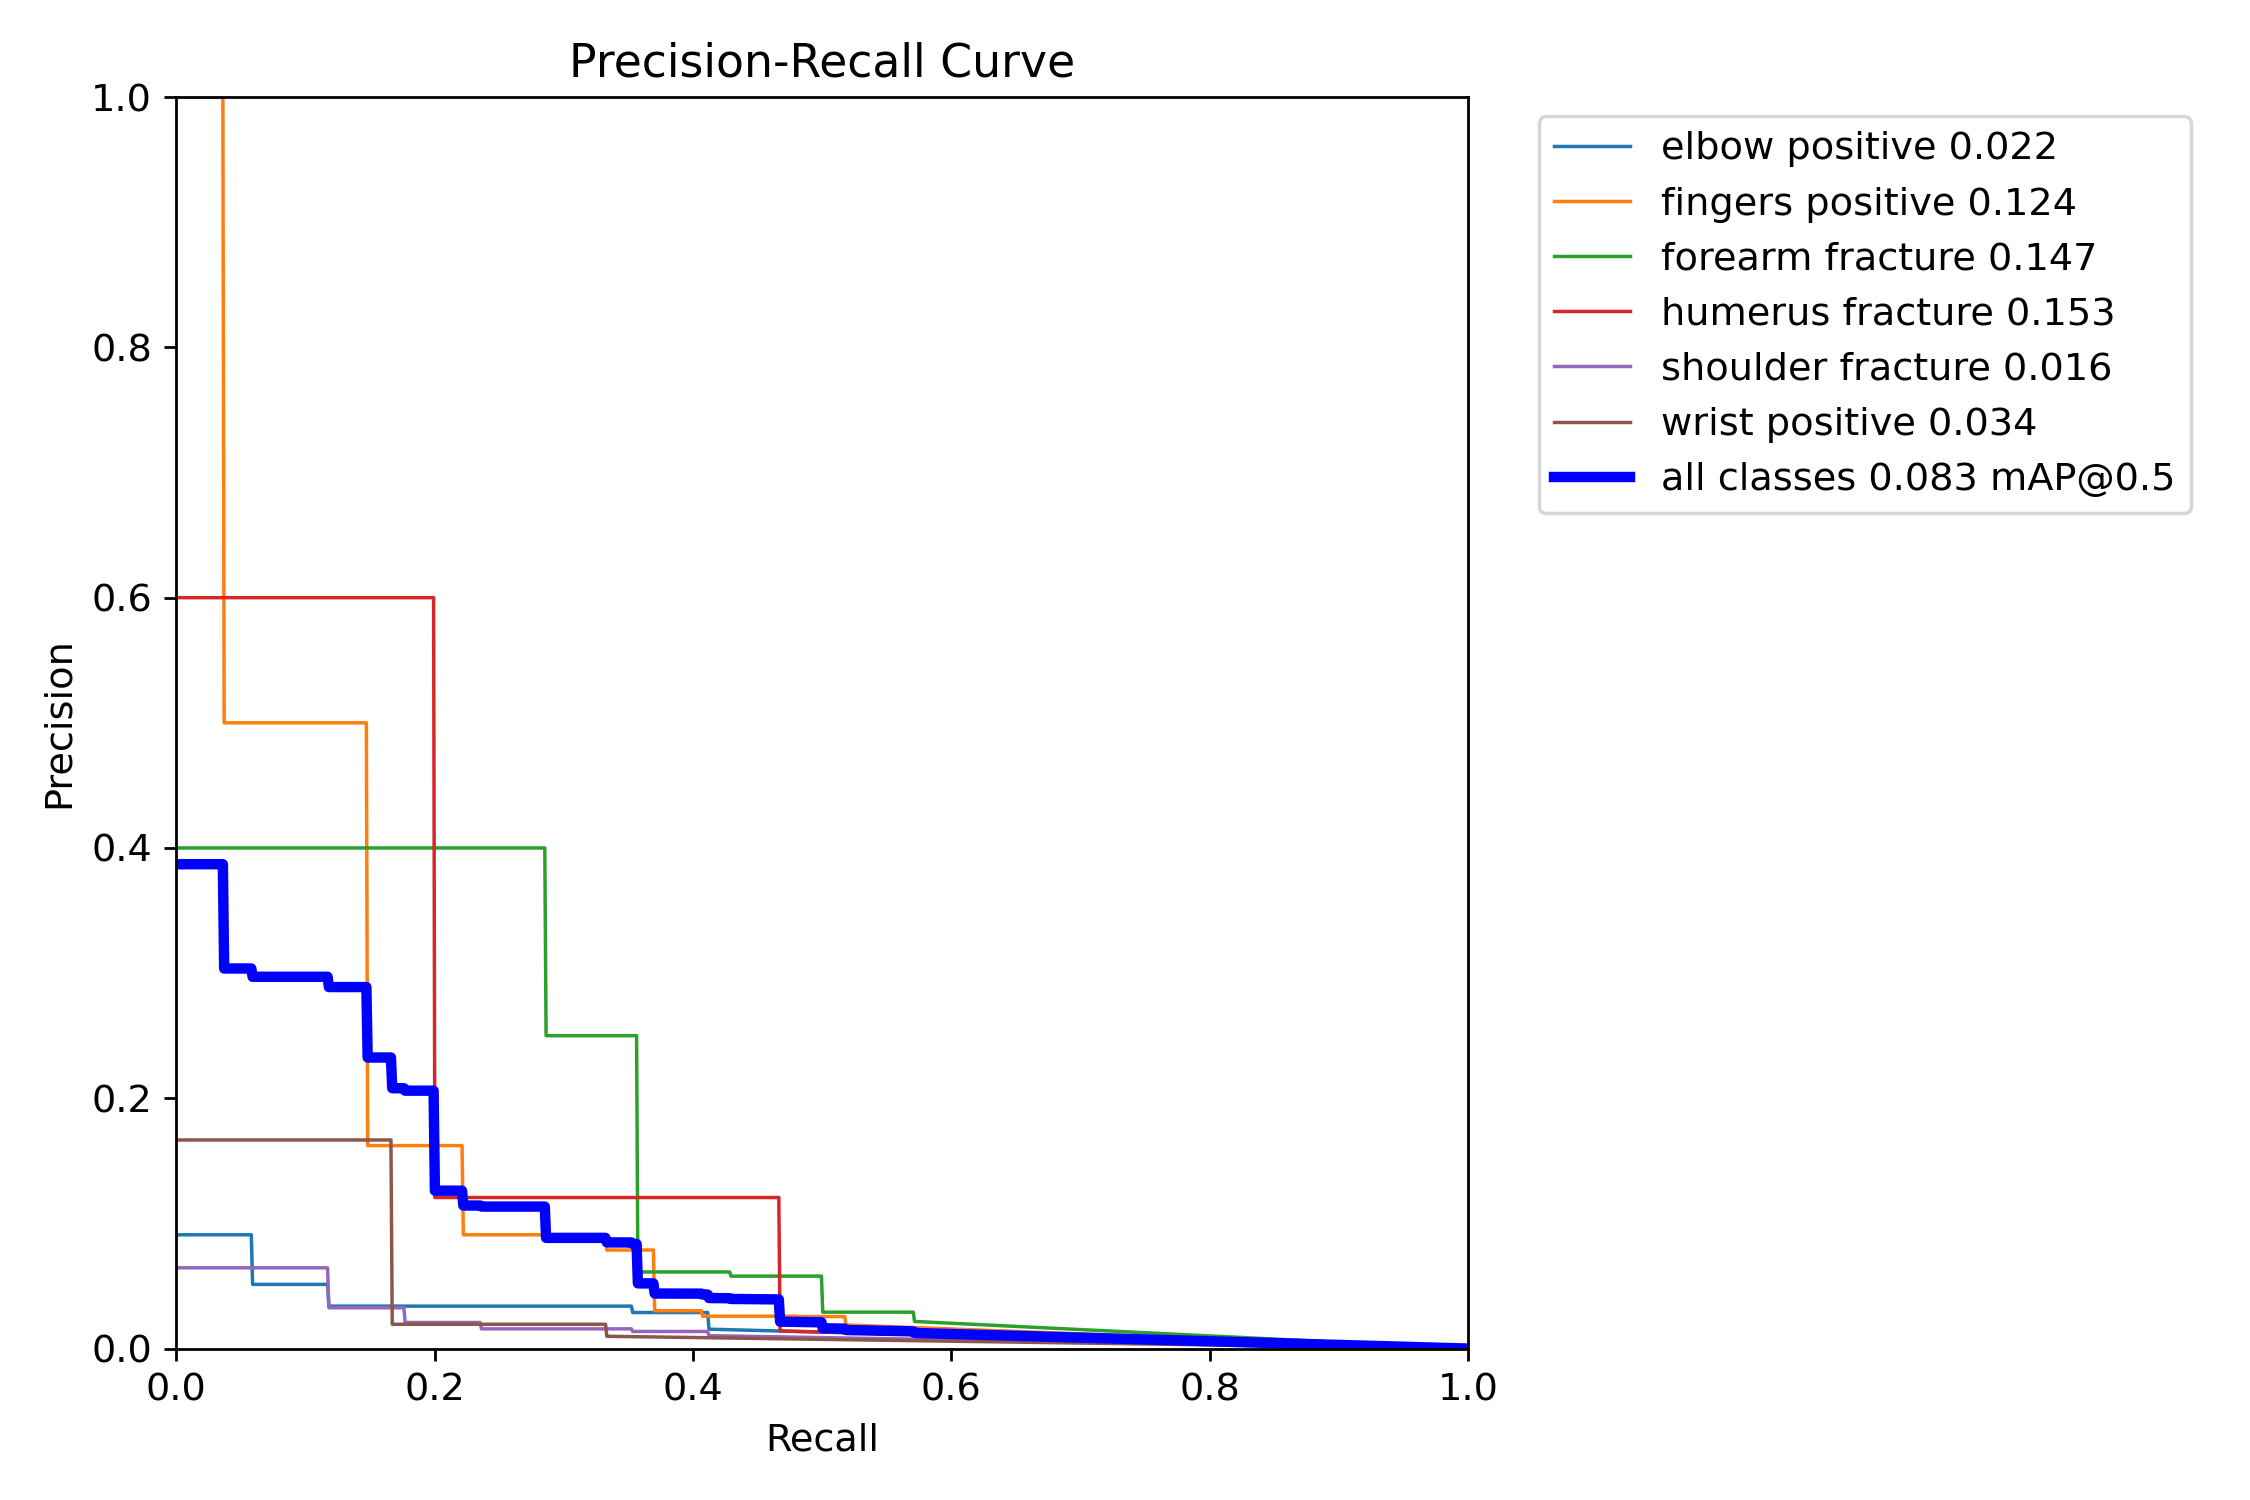

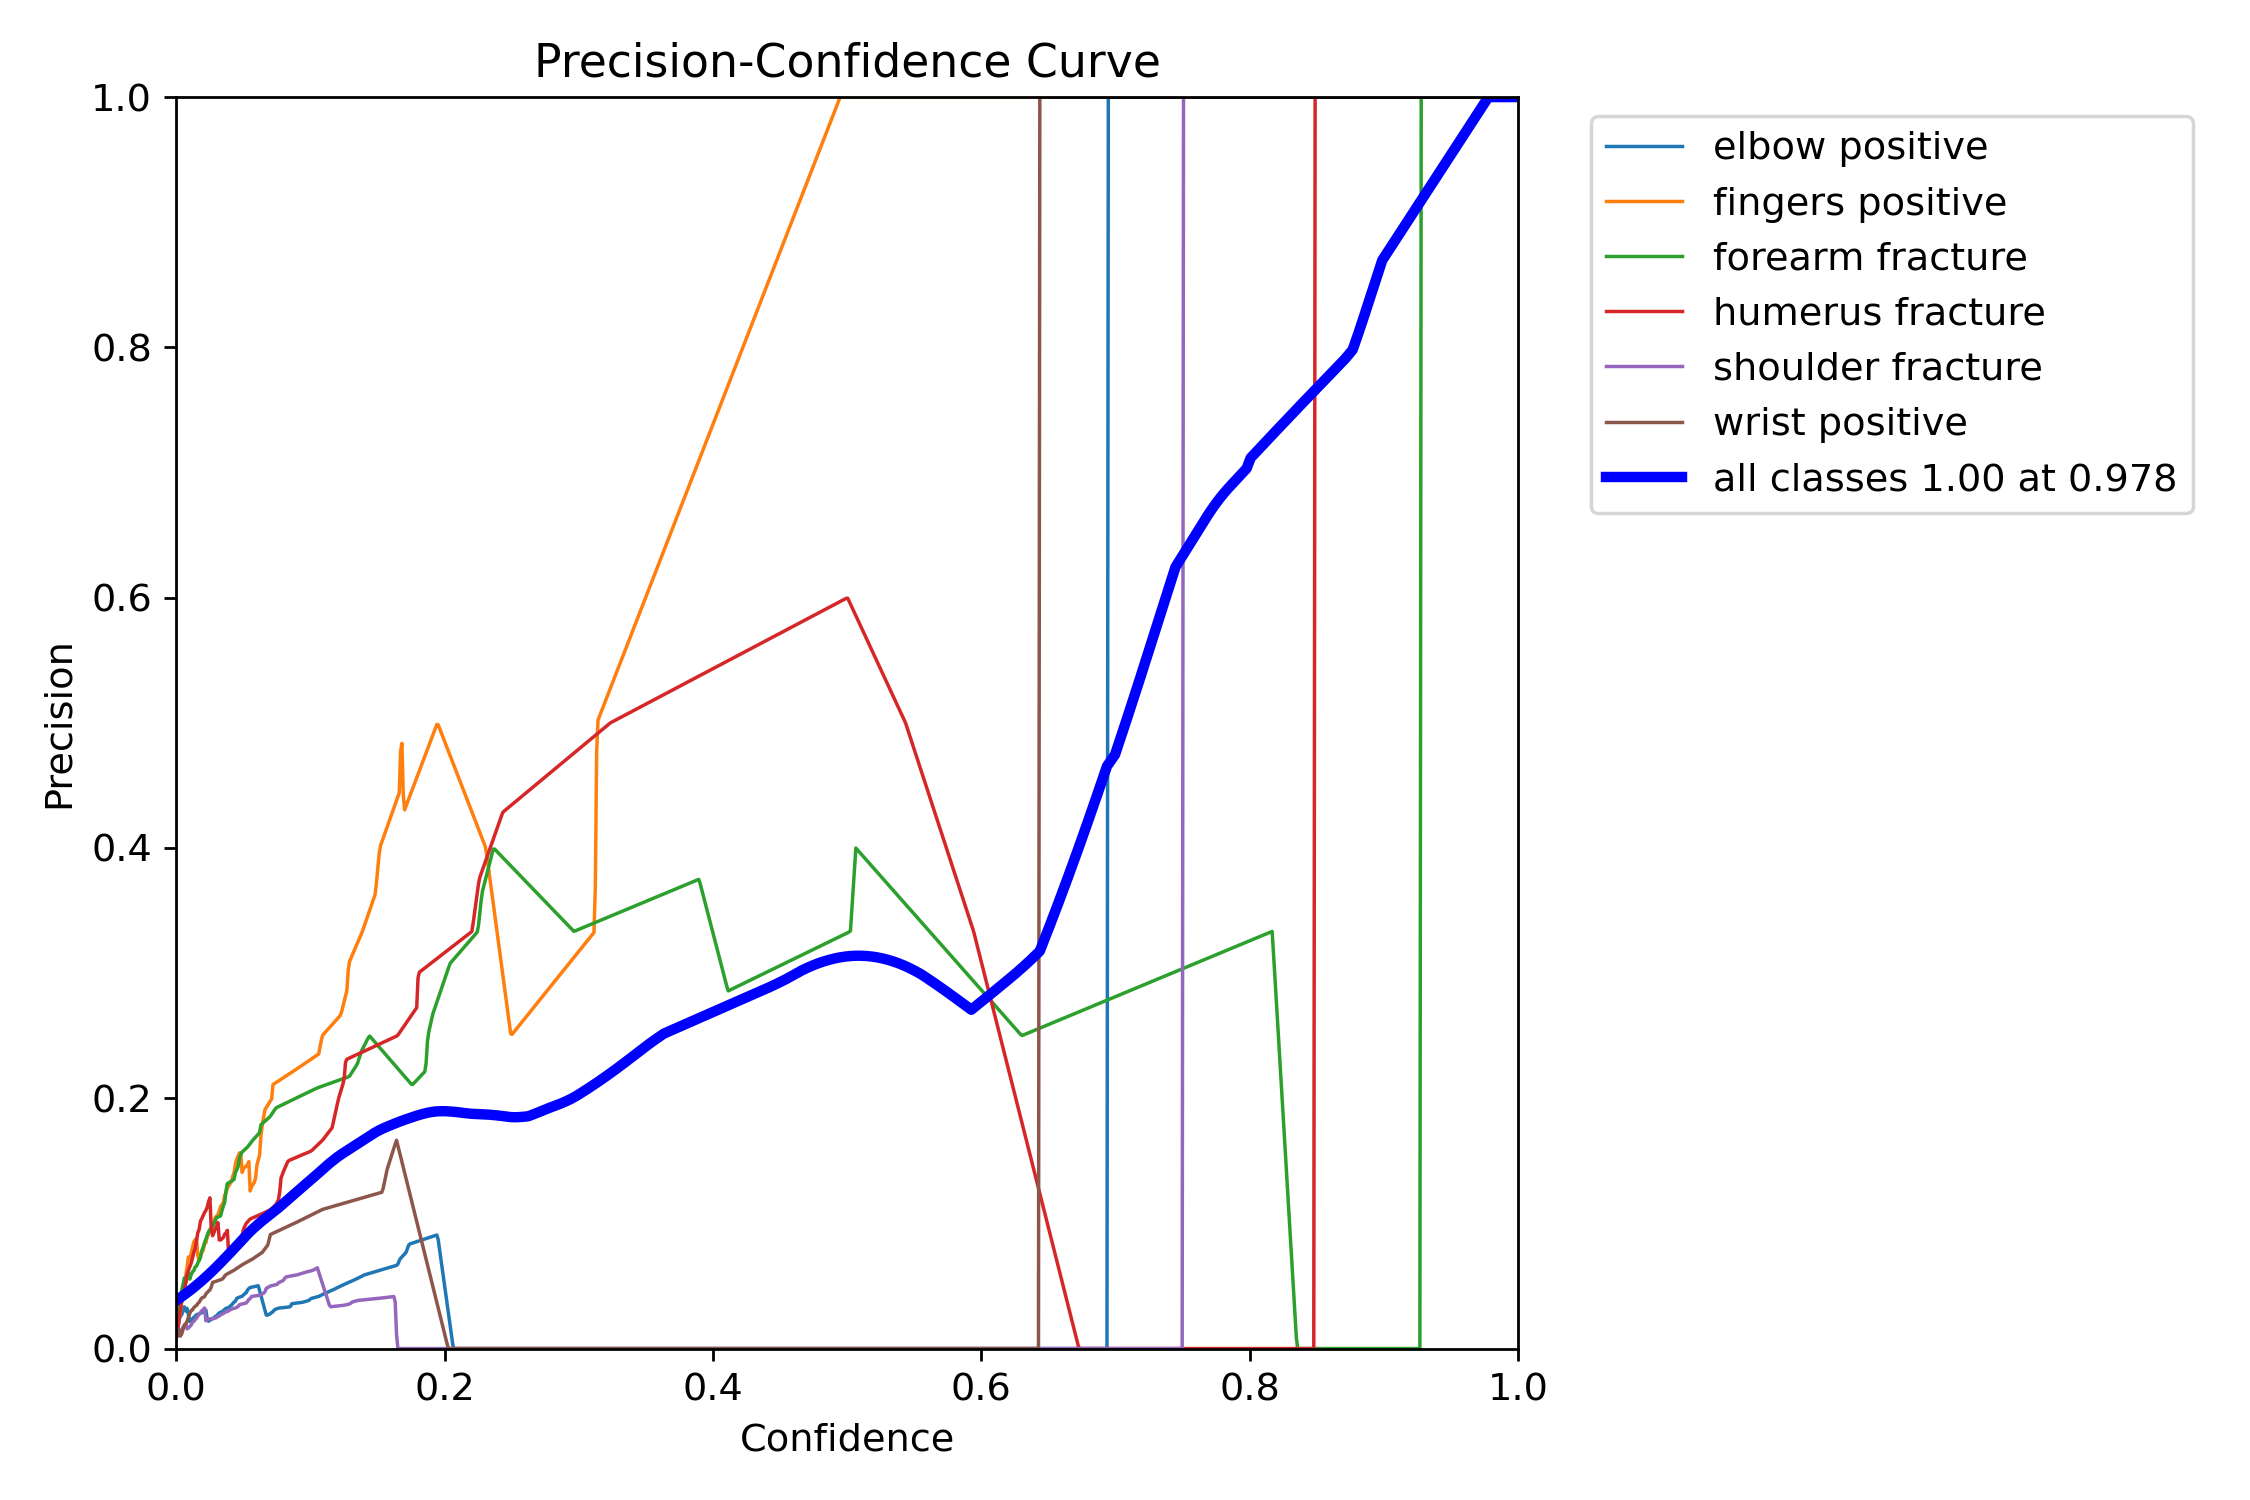

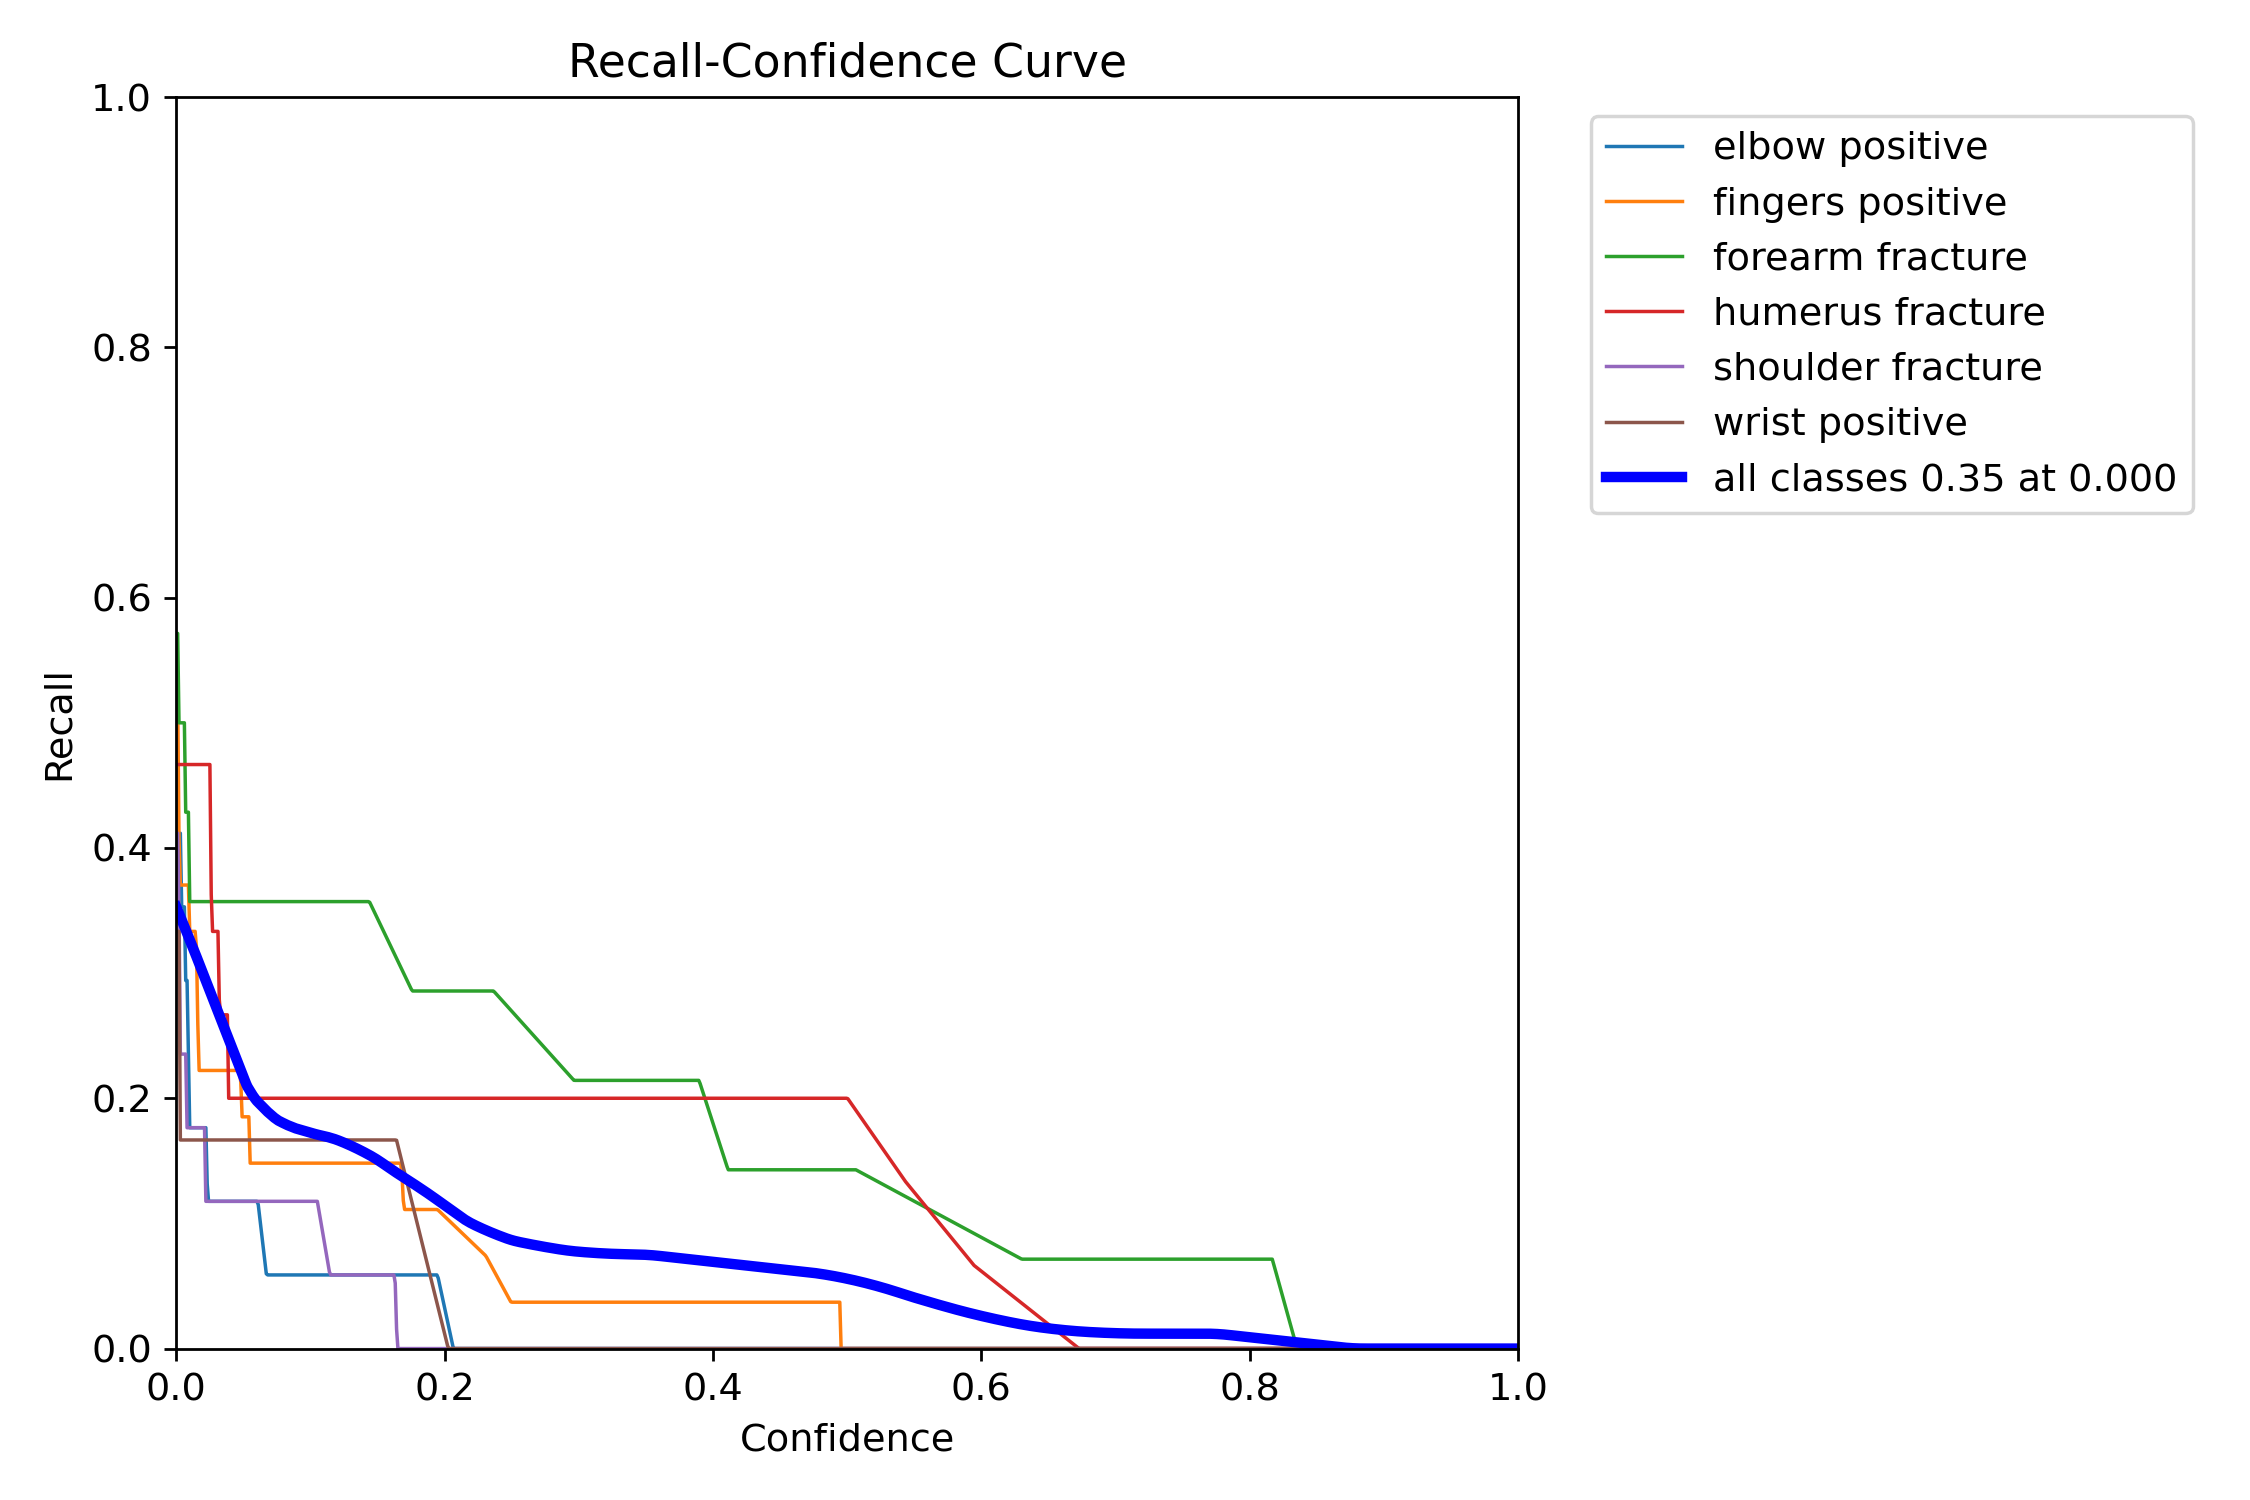

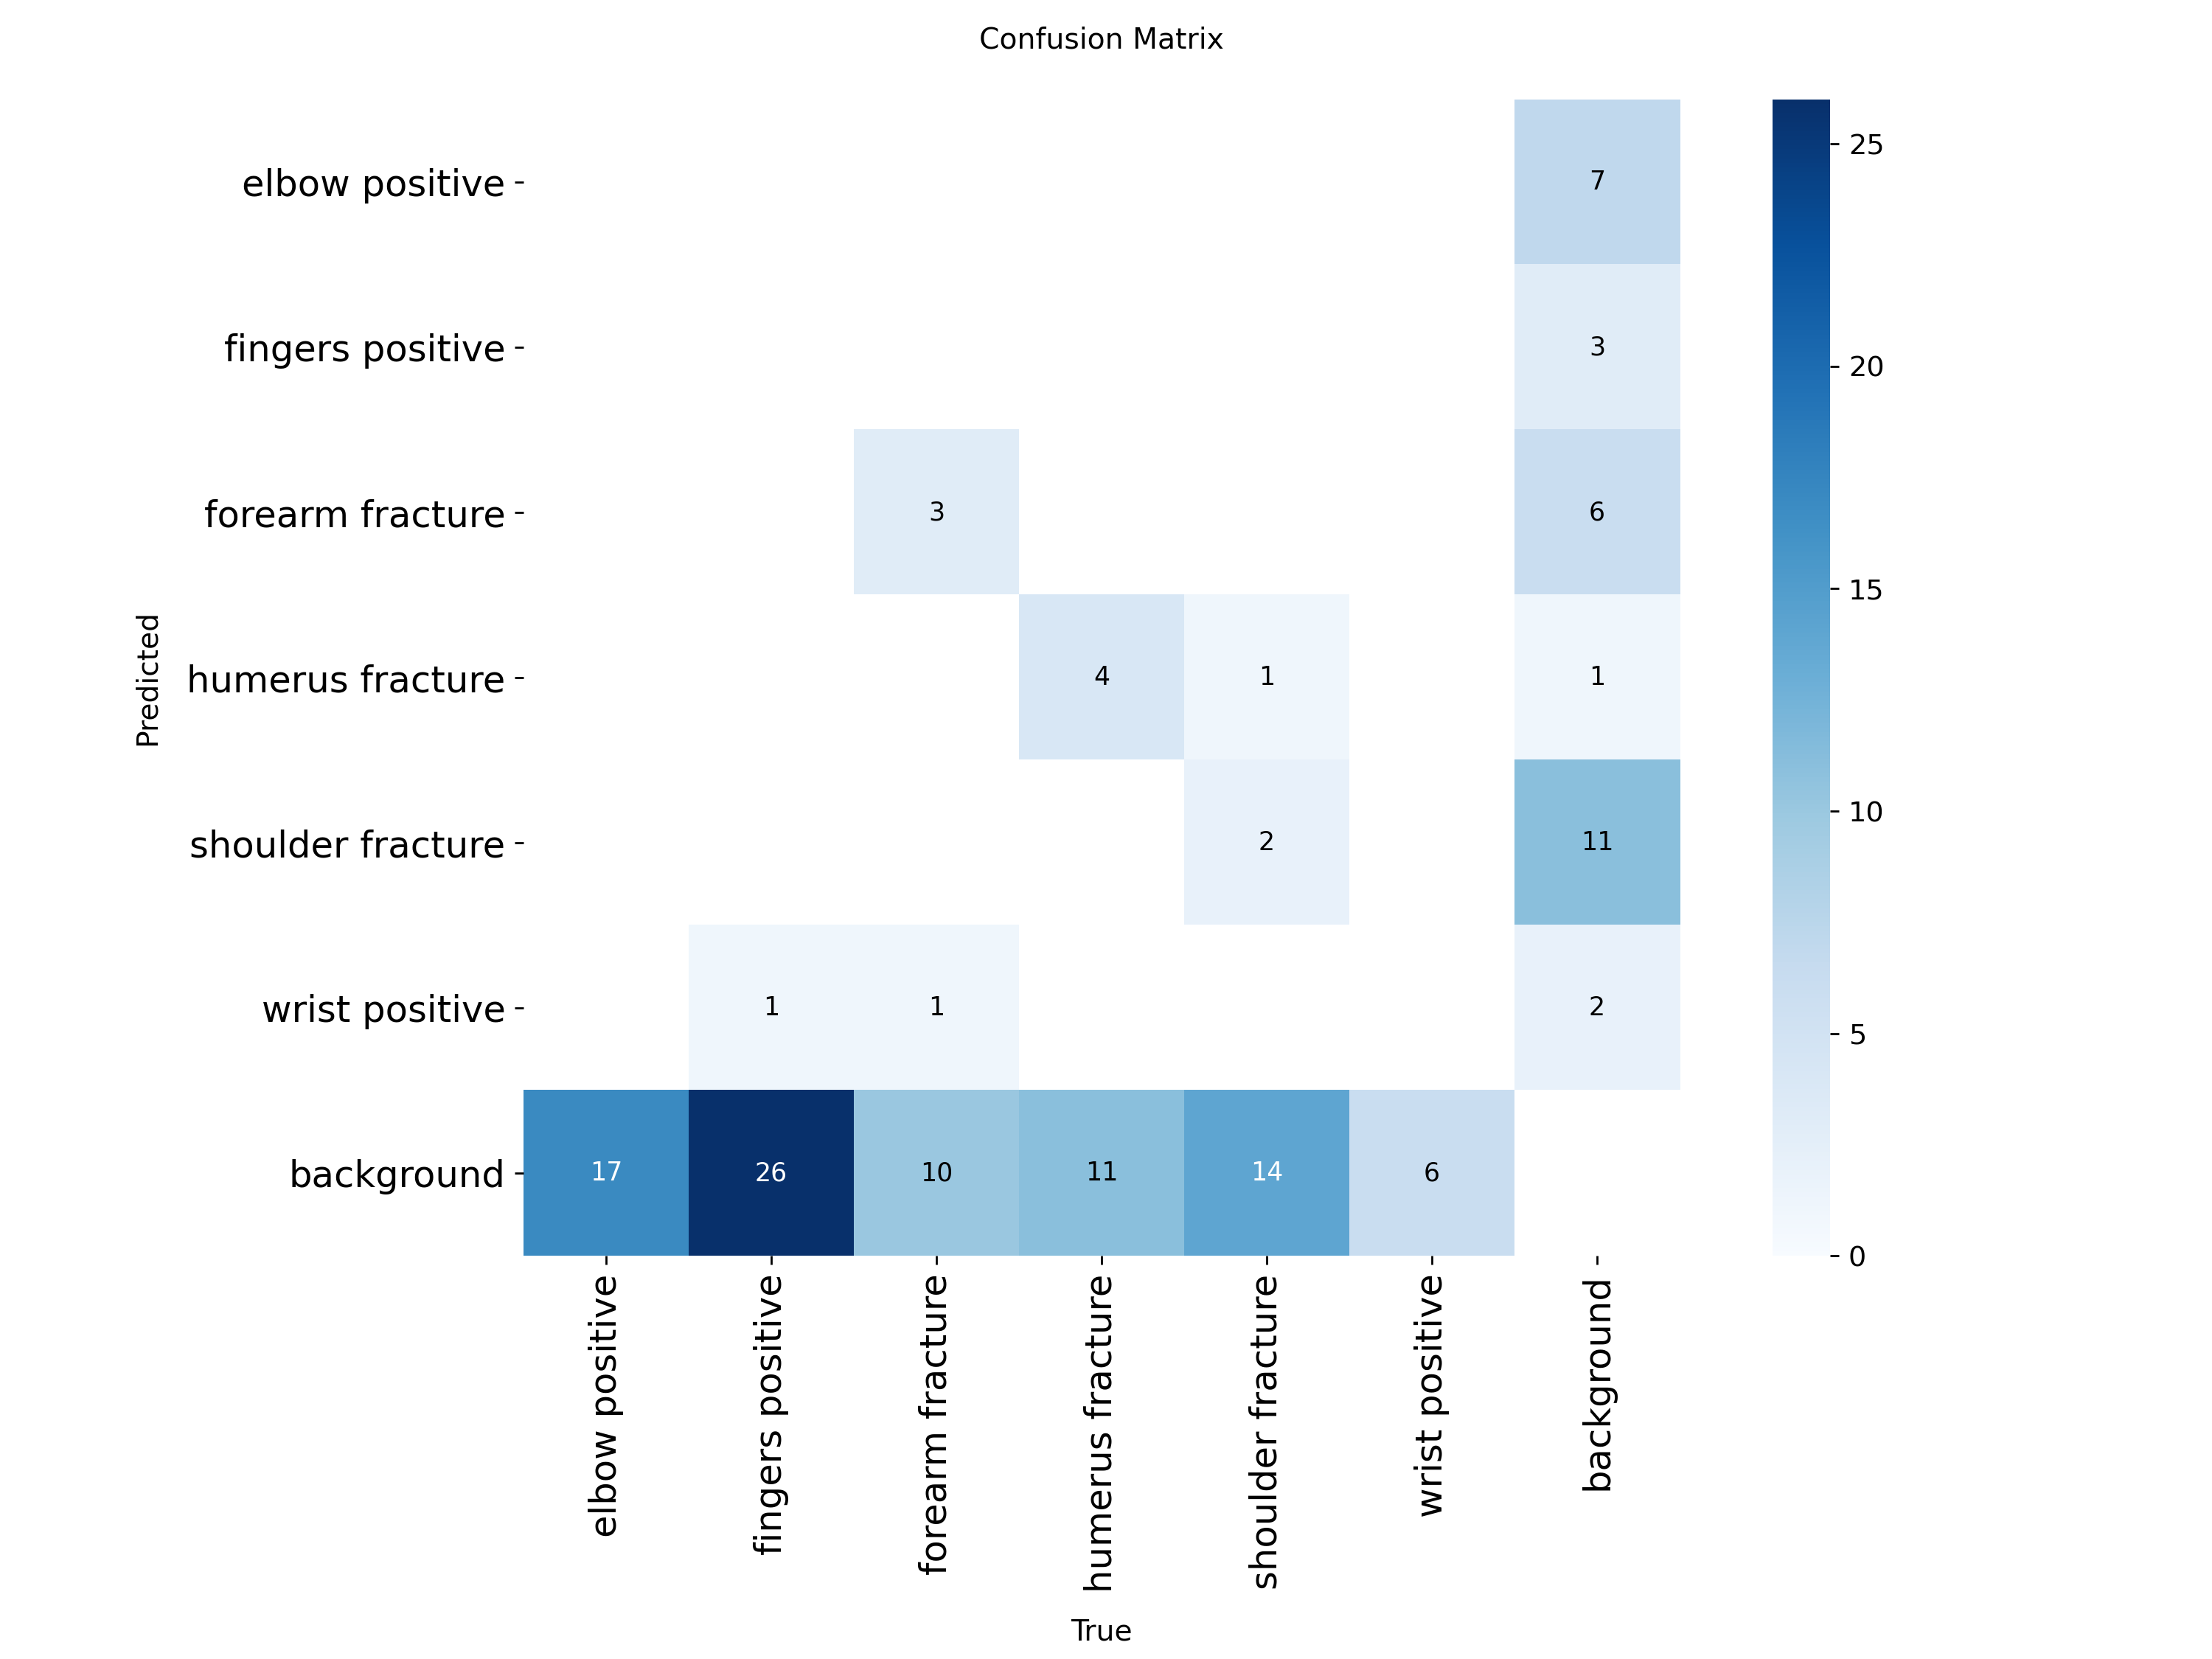

In [14]:
from IPython.display import Image, display

display(Image('/kaggle/working/runs/detect/first_train2/BoxF1_curve.png'))
display(Image('/kaggle/working/runs/detect/first_train2/BoxPR_curve.png'))
display(Image('/kaggle/working/runs/detect/first_train2/BoxP_curve.png'))
display(Image('/kaggle/working/runs/detect/first_train2/BoxR_curve.png'))
display(Image('/kaggle/working/runs/detect/first_train2/confusion_matrix.png'))

Desired Predictions


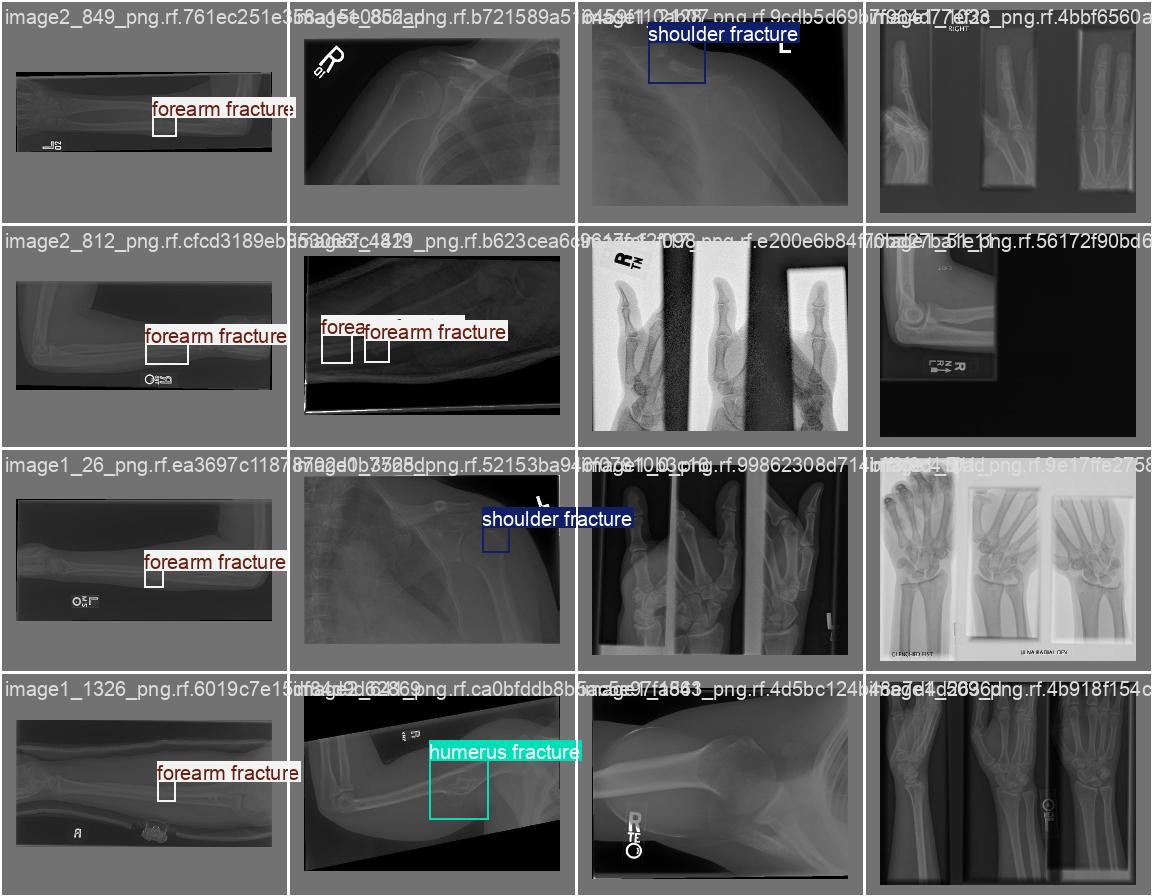

Actual Predictions


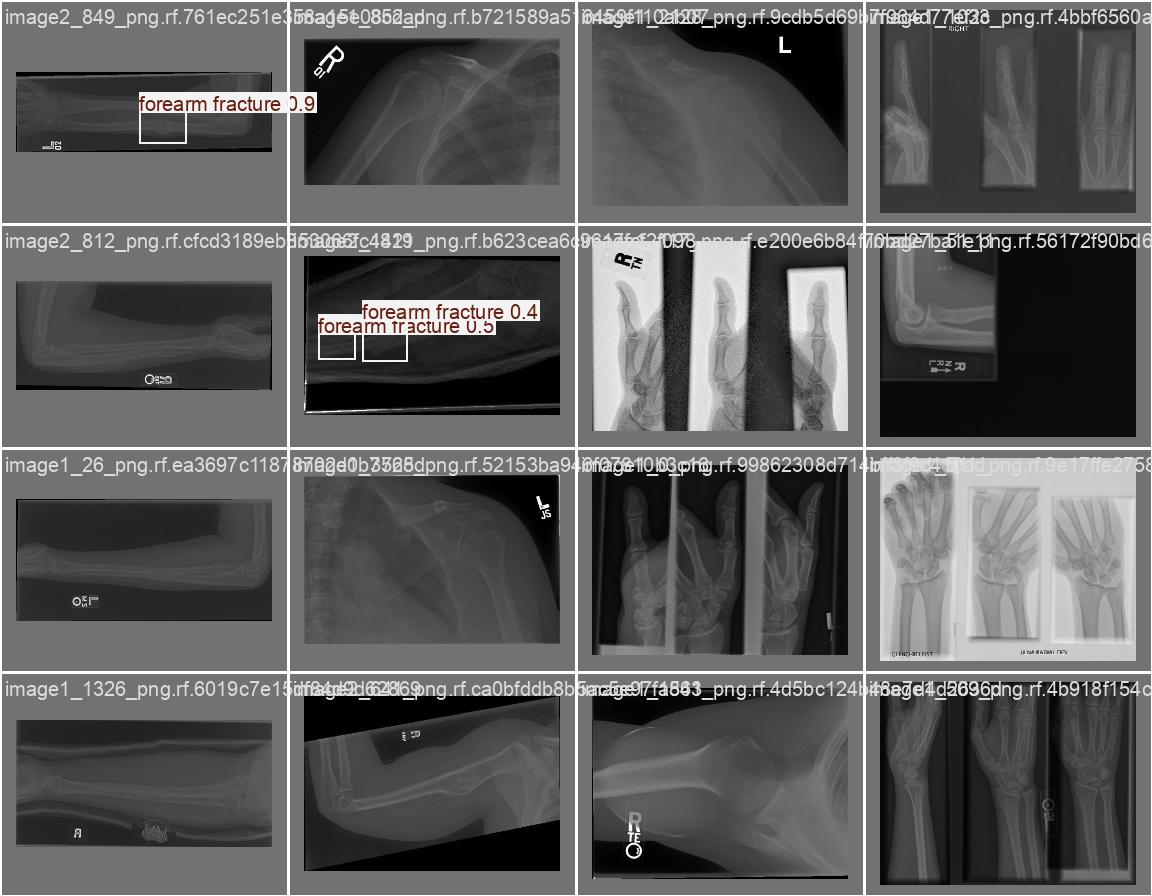

In [15]:
print('Desired Predictions')
display(Image('/kaggle/working/runs/detect/first_train2/val_batch0_labels.jpg'))
print('Actual Predictions')
display(Image('/kaggle/working/runs/detect/first_train2/val_batch0_pred.jpg'))